# Single Neuron Experiments

This tutorial introduces [Norse](norse.ai) and the concept of spiking neurons.
In the next 5-10 minutes or so you will learn about

- Spiking Neuron Models
- Gradient based learning with Spiking Neurons

## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [17]:
#!pip install --quiet norse
#!pip install show
#from show import *

import torch
import norse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False



{'cm': [1, 983.5],
 'v_spike': [-70.0, -20],
 'v_reset': [-100, -25],
 'v_rest': [-100, -35],
 'tau_m': [0.01, 62.78345],
 'a': [0.01, 20],
 'b': [0.01, 20],
 'delta_T': [1, 10],
 'tau_w': [0.05, 354],
 'v_thresh': [-65, -15],
 'spike_delta': [1.25, 135]}

In [2]:
import norse
from jithub.models import model_classes
model = model_classes.ADEXPModel()
from norse.torch.functional.lif import lif_step #there model
from neuronunit.optimization.model_parameters import MODEL_PARAMS#, BPO_PARAMS

MODEL_PARAMS['ADEXP']

In [ ]:
print(LIFParameters(alpha=alpha))

In [ ]:
from jithub.models import model_classes
       
class MyHackedNeurons(torch.nn.Module):
    def __init__(self, weights, alpha):
        super(MyHackedNeurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        
        self.lambda_vs = []
        self.lambda_is = []
        self.p = MODEL_PARAMS['ADEXP'].keys()
        

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []

    def forward(self, z_in):
        seq_length, batch_size, _ = z_in.shape
        hidden_size = self.hidden_size

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)
        #print(currents)
        z_s = torch.zeros(seq_length, batch_size, hidden_size)

        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

                
        model = model_classes.ADEXPModel()
        model.set_attrs(self.p)
        for ts in range(seq_length):
            """
            This is where the optimized singular LIF model is solved for
            """
            
            z, s = lif_step(z_in[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            z_s[ts,:] = z
        print(self.p)
        print(z_in, s, self.w_in, self.w_rec,)
        
        return z_s, voltages, currents

## Step 1: A simple neuron model

The point neuron models supported by Norse are almost all variants of the Leaky-Integrate and Fire neuron model. It is however relatively easy to implement your own model. The library
is build in layers, here I show an example of how to use the functional API directly. To
build large scale machine learning models, you should check out the tutorial on [PyTorch
lightning + Norse](high-performance-computing.ipynb).


In [3]:
from norse.torch.functional.lif import lif_step, LIFParameters, LIFState

class Neurons(torch.nn.Module):
    def __init__(self, weights, alpha):
        super(Neurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        
        self.lambda_vs = []
        self.lambda_is = []
        self.p = LIFParameters(alpha=alpha)

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []

    def forward(self, z_in):
        seq_length, batch_size, _ = z_in.shape
        hidden_size = self.hidden_size

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)
        #print(currents)
        z_s = torch.zeros(seq_length, batch_size, hidden_size)

        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

        for ts in range(seq_length):
            """
            This is where the optimized singular LIF model is solved for
            """
            z, s = lif_step(z_in[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            z_s[ts,:] = z
        print(self.p)
        
        return z_s, voltages, currents

## Step 2.1: Optimizing for a fixed number of spikes

A simple task to consider is a single neuron stimulated at different times by $k$ fixed poisson distributed spike trains, with synaptic weights distributed according to a gaussian distribution. The goal is for the neuron to respond to these fixed spike trains with a certain number of spikes $n_\text{target}$ within a time $T$. The loss in this case is
$$
l = -n_\text{target}/T + \sum_i \delta(t - t_i) 
$$
so
$$
S = \int_0^T (-n_\text{target}/T + \sum_i \delta(t - t_i)) dt = n_\text{actual} - n_\text{target}
$$

In [4]:
from tqdm.notebook import trange

def run_training(
    w_in,
    z_in,
    alpha=100.0,
    max_epochs=100,
    target_spikes=6,
    target_spike_offset=10
):
    neurons = MyHackedNeurons(w_in, alpha=torch.tensor(alpha))
    print(neurons.p,"this is the parameter set that controls the neuronal model")
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []

    pbar = trange(max_epochs)
    for e in pbar:
        optim.zero_grad()
        z_s, voltages, currents = neurons(z_in)

        # compute the loss according to the formula above
        loss = torch.sum(torch.abs((torch.sum(z_s, axis=0) - target_spikes)))
        loss.backward()

        pbar.set_postfix({"spike difference": loss.detach().item()})

        # keep track of the experiment data
        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)     
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.reset_lambda_recording()

        if loss.data == torch.tensor([0.0]):
            break

        # do a gradient optimisation step
        optim.step()

    return spikes_out, vs, cs, lambda_vs, lambda_is

In [5]:
seq_length = 1000
input_size = 20
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)



spikes, vs, cs, lambda_vs, lambda_is = run_training(z_in=z_in, w_in=w_in, alpha=alpha, target_spikes=6, max_epochs=epochs)

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)) this is the parameter set that controls the neuronal model


LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

Don't worry that the progress bar turned red, in this case it means that the optimisation
finished early. We can plot the error signals that are propagated backwards in time as follows. At each spike that reaches the neuron at synapse the variable $\lambda_i$ is accumulated to the gradient
of the synaptic weight.

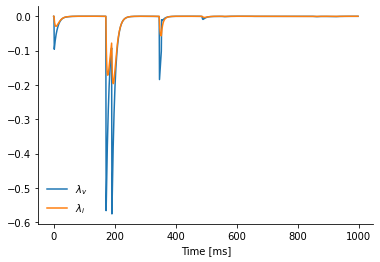

In [6]:
import matplotlib.pyplot as plt

epoch_from_last = 2
plt.plot(lambda_vs[-epoch_from_last][:,0], label='$\lambda_v$')
plt.plot(lambda_is[-epoch_from_last][:,0], label='$\lambda_i$')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

Exercises:
- Change the epoch_from_last variable to plot the error traces at different times in the optimisation
  procedure.
- Change the value alpha. What do you observe?
- Repeat the experiment with more biologically realistic parameters


In [7]:
#norse.torch.functional.lif.LIFParameters?
print(dir(norse.torch.functional.lif.LIFParameters))
"""


where :math:`z_{\text{rec}}` and :math:`z_{\text{in}}` are the recurrent
and input spikes respectively.

Parameters:
    input_tensor (torch.Tensor): the input spikes at the current time step
    s (LIFState): current state of the LIF neuron
    input_weights (torch.Tensor): synaptic weights for incoming spikes
    recurrent_weights (torch.Tensor): synaptic weights for recurrent spikes
    p (LIFParameters): parameters of a leaky integrate and fire neuron
    dt (float): Integration timestep to use
"""

['__add__', '__annotations__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_field_types', '_fields', '_fields_defaults', '_make', '_replace', 'alpha', 'count', 'index', 'method', 'tau_mem_inv', 'tau_syn_inv', 'v_leak', 'v_reset', 'v_th']


'\n\n\nwhere :math:`z_{\text{rec}}` and :math:`z_{\text{in}}` are the recurrent\nand input spikes respectively.\n\nParameters:\n    input_tensor (torch.Tensor): the input spikes at the current time step\n    s (LIFState): current state of the LIF neuron\n    input_weights (torch.Tensor): synaptic weights for incoming spikes\n    recurrent_weights (torch.Tensor): synaptic weights for recurrent spikes\n    p (LIFParameters): parameters of a leaky integrate and fire neuron\n    dt (float): Integration timestep to use\n'

## Step 2.2: Learning target spike times

Another task is for one neuron to spike at specific spike times $t_0, \ldots, t_N$ given that it stimulated 
by a fixed set of poisson distributed spikes. We can choose as a loss in this case
$$
l = \sum_i \lvert v - v_{\text{th}} \rvert^2 \delta(t - t_i) + l_N
$$
that is we require the membrane voltages to be close to the threshold $v_{th}$ at the required spike times $t_i$
and penalise the neuron if it spikes more or less than the required number of times.

In [8]:
from tqdm.notebook import trange

def run_target_spike_time_training(
    w_in,
    z_in,
    alpha=100.0,
    epochs=4000,
    target_times=[100, 300, 500, 700]
):
    #print("w_in",w_in)
    neurons = Neurons(w_in, alpha=torch.tensor(alpha))
    params = neurons.parameters()

    optim = torch.optim.SGD(params, lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []
    

    v_target = torch.zeros(seq_length, batch_size, hidden_size)
    target_spikes = len(target_times)

    for time in target_times:  
        v_target[time,:] = 1.1 * torch.ones(hidden_size)
    
    pbar = trange(epochs)
    for e in pbar:
        optim.zero_grad()
        
        #print(z_in)
        z_s, voltages, currents = neurons(z_in)
        #print(currents)
        #print(z_s,'zs',type(z_s))
        loss = torch.zeros(1,1)
        for time in target_times:    
            loss += 1/2 * 1/10 * (voltages[time,:] - v_target[time,:])**2

        dspikes = torch.sum(torch.abs(torch.sum(z_s, axis=0) - target_spikes))
        loss += dspikes
        loss.backward()

        pbar.set_postfix({"loss": loss.detach().item(), "spike difference": dspikes.detach().item()})

        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        print(neurons.p)
        neurons.lambda_vs = []
        neurons.lambda_is = []
        if loss.data == torch.tensor([0.0]):
            break

        optim.step()
        #print(optim.param_groups,optim.state,optim.state_dict,optim.step,optim.zero_grad)
        #print(dir(optim))

    return spikes_out, vs, vs, lambda_vs, lambda_is

In [9]:
neurons = Neurons(w_in, alpha=torch.tensor(alpha))
params = neurons.parameters()
print([p for p in params])
params = neurons.parameters()

optim = torch.optim.SGD(params, lr=0.1)
print(neurons.p)
print(w_in)

[Parameter containing:
tensor([[ 0.3094, -2.5103,  0.1425, -0.8485, -1.6768, -1.7131, -0.4260,  2.0651,
         -0.9261, -0.0048,  1.1744, -0.1075,  1.0624, -0.6144, -0.9731, -1.6142,
         -0.7598,  0.3864, -0.1381, -1.2306]], requires_grad=True)]
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
[[ 0.30943701 -2.51027474  0.1424722  -0.84849839 -1.67683841 -1.71312517
  -0.42595045  2.06514642 -0.92613284 -0.00475344  1.17435849 -0.10746591
   1.06239922 -0.61436033 -0.97311783 -1.61421963 -0.75976173  0.38635059
  -0.13805205 -1.23062006]]


In [10]:
seq_length = 1000
input_size = 50
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0
target_times = [100, 300, 500, 700]


w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
result = run_target_spike_time_training(
    w_in=w_in, 
    z_in=z_in,
    alpha=alpha, 
    epochs=epochs, 
    target_times=target_times
)

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.))
LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=

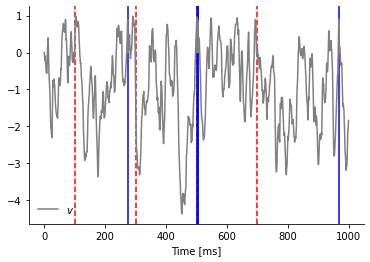

In [11]:
spikes, vs, cs, lambda_vs, lambda_is = result

actual_times = spikes[-1][:,0,0].to_sparse().indices()[0]


for ts in target_times:
    plt.axvline(x=ts, color='red', linestyle='--')

for ts in list(actual_times):
    plt.axvline(x=ts, color='blue', linestyle='-')

plt.plot(vs[-1][:,0], color='grey', label='$v$')
plt.xlabel('Time [ms]')
plt.legend()

We again visualise the error traces over time.

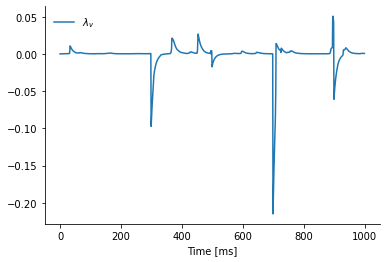

In [12]:
plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.xlabel('Time [ms]')
plt.legend()

Exercises:
- This task doesn't actually great, can you think of ways to improve it?
- What additions to the loss could one consider to make the task more stable?
- Explore different values for alpha, target_times and input size, what do you observe?
- Consider a different optimiser
- Consider using biologically plausible neuron parameters